# 2020 SEG Annual Meeting Machine Learning Interpretation Workshop

A 3D seismic data volume and an accompanying "label" volume consisting of a seismic facies interpretation.
Each pixel in the label volume is assigned a value from 1 to 6, denoting its facies classification:

1. Basement/Other: Basement - Low S/N; Few internal Reflections; May contain volcanics in places
2. Slope Mudstone A: Slope to Basin Floor Mudstones; High Amplitude Upper and Lower Boundaries; Low Amplitude Continuous/Semi-Continuous Internal Reflectors
3. Mass Transport Deposit: Mix of Chaotic Facies and Low Amplitude Parallel Reflections
4. Slope Mudstone B: Slope to Basin Floor Mudstones and Sandstones; High Amplitude Parallel Reflectors; Low Continuity Scour Surfaces
5. Slope Valley: High Amplitude Incised Channels/Valleys; Relatively low relief
6. Submarine Canyon System: Erosional Base is U shaped with high local relief.  Internal fill is low amplitude mix of parallel inclined surfaces and chaotic disrupted reflectors.  Mostly deformed slope mudstone filled with isolated sinuous sand-filled channels near the basal surface.

Your task is to use this training dataset to build a machine-learning model that can predict the facies classifications for each pixel in a different, unlabeled 3D seismic volume with the same six facies categories.

Around September 1, one or more such volumes will be posted on this page (if you provided your email address before accessing this page, you will be notified when these test volumes are available). At that time, you may apply your model to the new dataset(s) and submit your "answers" to the workshop organizers. Participants will be judged primarily using the average of the Intersection over Union (IoU) scores for the six facies categories, although the Organizers reserve the right to use additional qualitative and quantitative metrics to gauge performance.

In [11]:
import os
import numpy as np

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams
from plotting import plot_label
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams.update({
    'image.cmap'     : 'gray',
    'axes.grid'      : False,
    'savefig.dpi'    : 300,  # to adjust notebook inline plot size
    'axes.labelsize' : 14,  # fontsize for x and y labels (was 10)
    'axes.titlesize' : 14,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : False
})

In [2]:
CLASS_NAMES = ["Basement", "SlopeMudA", "Deposit", "SlopeMudB", "SlopeValley", "Canyon"]
num_classes = len(CLASS_NAMES)

In [3]:
dataset = "/nas/public/dataset/geophysics/BlindTestSEG/"

## Train dataset

In [4]:
image = np.load(os.path.join(dataset, "train_image.npy"))
label = np.load(os.path.join(dataset, "train_labels.npy")).astype(np.uint8)-1

In [5]:
print('x\ty\tz')
print('%d\t%d\t%d' % (image.shape[0],image.shape[1],image.shape[2]))

x	y	z
590	782	1006


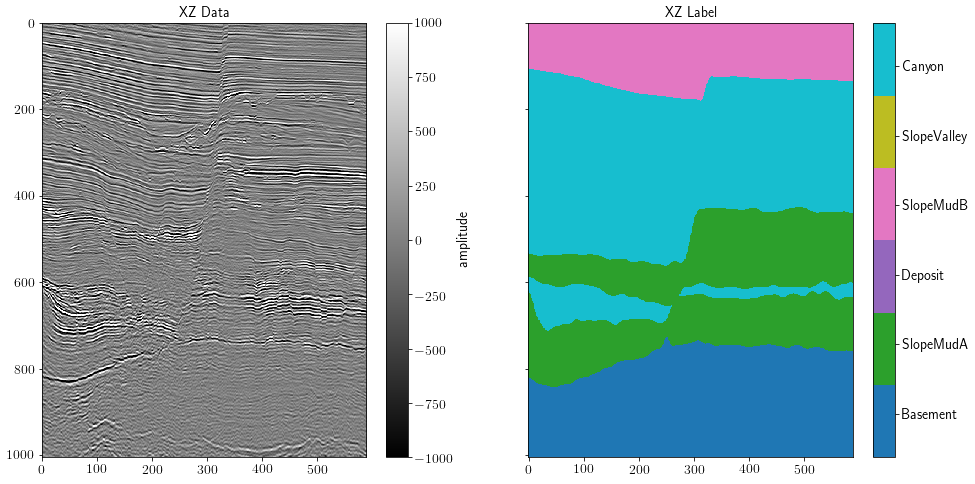

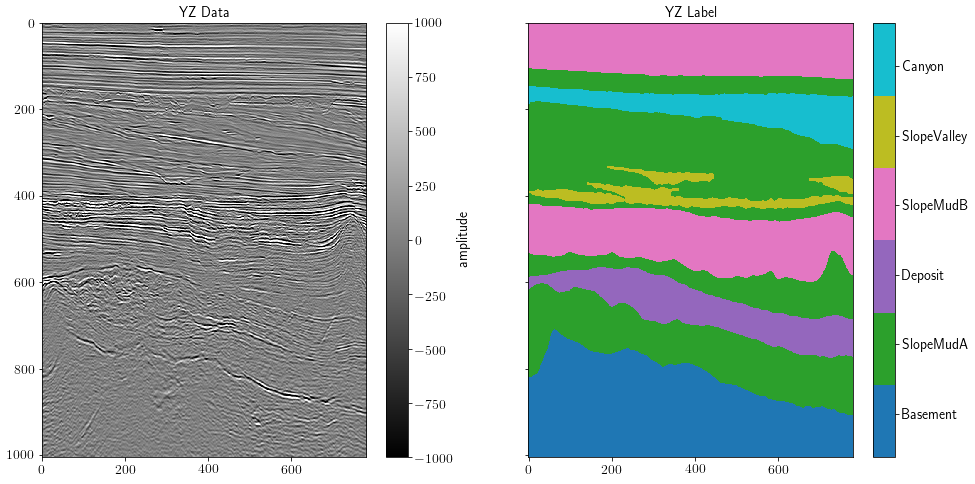

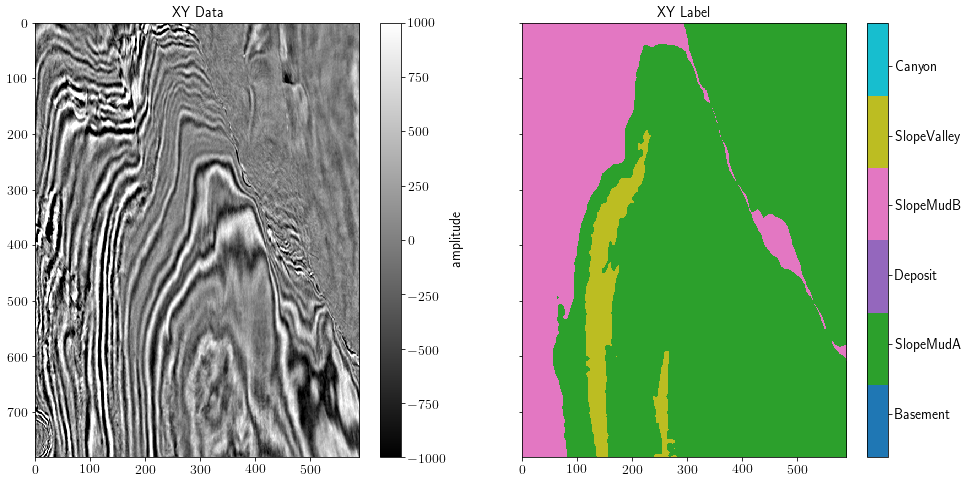

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 8))

data=axs[0].imshow(image[:,0].T, clim=(-1000,1000))
axs[0].set_title('XZ Data')
axs[0].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')

plot_label(label[:,0].T, fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[1].set_title('XZ Label')
axs[1].axis('tight')
           
plt.show()


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 8))

data=axs[0].imshow(image[0].T, clim=(-1000,1000))
axs[0].set_title('YZ Data')
axs[0].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')

plot_label(label[0].T, fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[1].set_title('YZ Label')
axs[1].axis('tight')
           
plt.show()


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 8))

data=axs[0].imshow(image[:,:,500].T, clim=(-1000,1000))
axs[0].set_title('XY Data')
axs[0].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')

plot_label(label[:,:,500].T, fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[1].set_title('XY Label')
axs[1].axis('tight')
           
plt.show()

Classes are quite unbalanced!

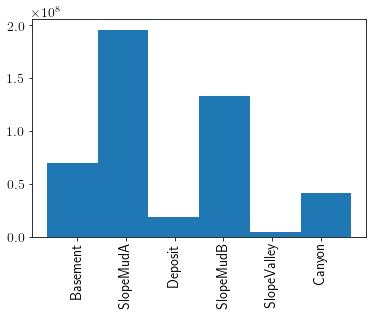

In [7]:
plt.hist(label.ravel(), num_classes)
plt.xticks(np.linspace(0.5,num_classes-1.5,num_classes), CLASS_NAMES, rotation=90)
plt.show()

### Extract edges

In [6]:
from skimage.feature import canny
from skimage.morphology import binary_dilation

In [47]:
edge=np.asarray(np.gradient(label)).sum(axis=0)

In [49]:
binary_edge = binary_mask(edge)

In [45]:
from utils import binary_mask

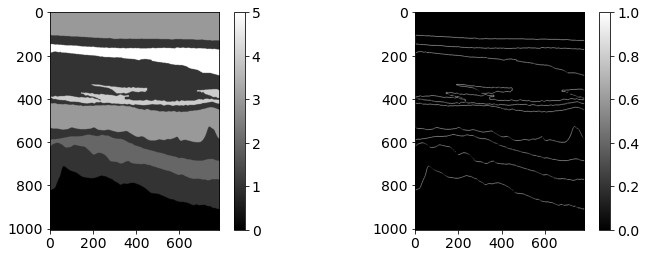

In [50]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.imshow(label[0].T), plt.colorbar()
plt.subplot(122), plt.imshow(binary_edge[0].T), plt.colorbar()
plt.show()

In [52]:
np.save(os.path.join("/nas/home/fpicetti/datasets/seg_blind_test", "train_labels_interfaces.npy"), binary_edge)

## Test dataset

In [7]:
test_image1 = np.load(os.path.join(dataset, "test_image1.npy"))
test_image2 = np.load(os.path.join(dataset, "test_image2.npy"))

In [8]:
print('Image 1\nx\ty\tz')
print('%d\t%d\t%d' % (test_image1.shape[0],test_image1.shape[1],test_image1.shape[2]))
print('Image 2\nx\ty\tz')
print('%d\t%d\t%d' % (test_image2.shape[0],test_image2.shape[1],test_image2.shape[2]))

Image 1
x	y	z
251	782	1006
Image 2
x	y	z
841	334	1006


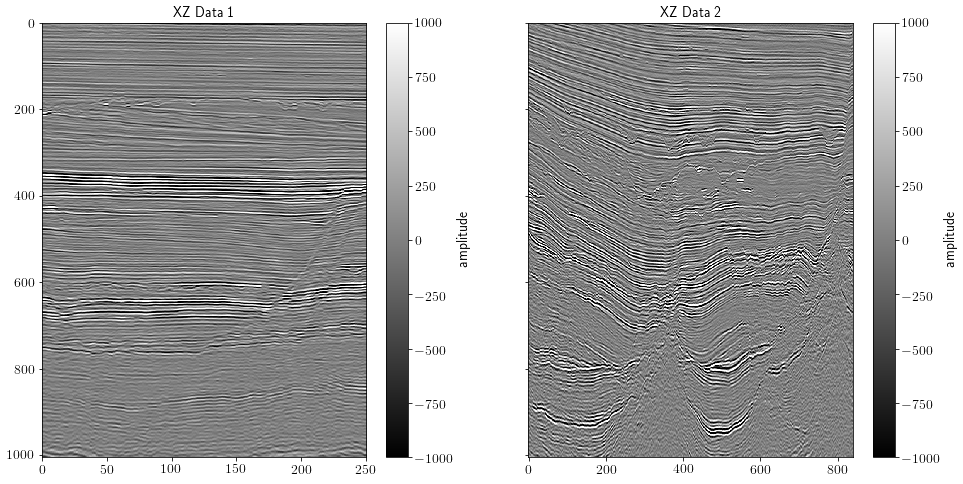

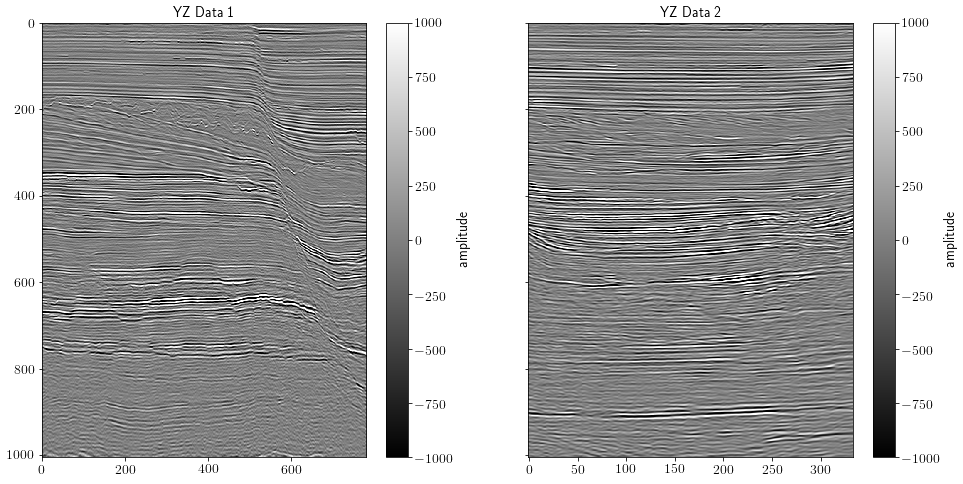

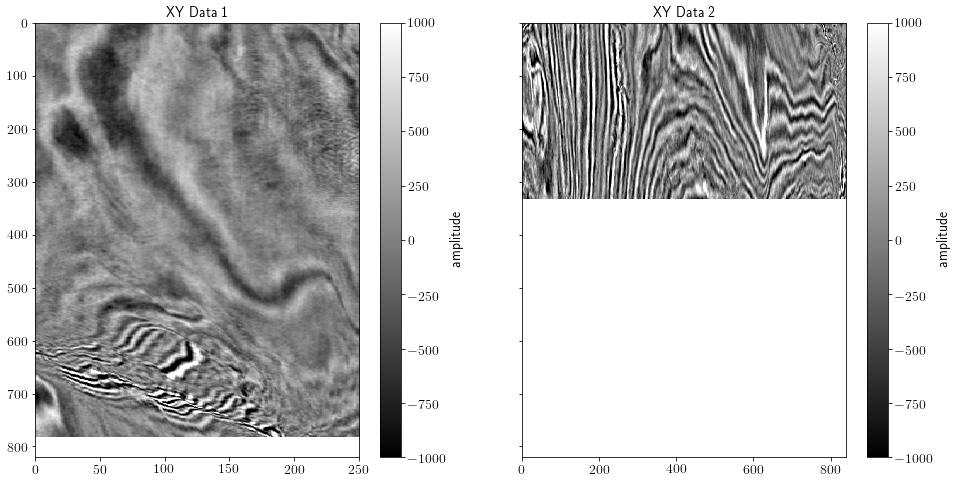

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
data=axs[0].imshow(test_image1[:,0].T, clim=(-1000,1000))
axs[0].set_title('XZ Data 1')
axs[0].axis('tight')
mask=axs[1].imshow(test_image2[:,0].T, clim=(-1000,1000))
axs[1].set_title('XZ Data 2')
axs[1].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')
fig.colorbar(mask, ax=axs[1],  label='amplitude')
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
data=axs[0].imshow(test_image1[0].T, clim=(-1000,1000))
axs[0].set_title('YZ Data 1')
axs[0].axis('tight')
mask=axs[1].imshow(test_image2[0].T, clim=(-1000,1000))
axs[1].set_title('YZ Data 2')
axs[1].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')
fig.colorbar(mask, ax=axs[1],  label='amplitude')
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
data=axs[0].imshow(test_image1[:,:,503].T, clim=(-1000,1000))
axs[0].set_title('XY Data  1')
axs[0].axis('tight')
mask=axs[1].imshow(test_image2[:,:,503].T, clim=(-1000,1000))
axs[1].set_title('XY Data 2')
axs[1].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')
fig.colorbar(mask, ax=axs[1],  label='amplitude')
plt.show()